In [68]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from oemof.solph import (Sink, Source, Transformer, Bus, Flow, Model,
                         EnergySystem, Investment, NonConvex)
import oemof.outputlib as outputlib
import oemof.solph as solph
import numpy as np
import pyomo.environ as po
import time
solver = 'cbc'

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [8.0, 6.0]

In [69]:
datetimeindex = pd.date_range('1/1/2016', periods=24*10, freq='H')
filename = 'input_data.csv'
data = pd.read_csv(filename, sep=",")


def run_basic_energysystem(epc_wind, epc_solar):
    start = time.time()
    # initialize and provide data
    energysystem = EnergySystem(timeindex=datetimeindex)

    # buses
    bcoal = Bus(label='coal', balanced=False)
    bgas = Bus(label='gas', balanced=False)
    bel = Bus(label='electricity')
    energysystem.add(bcoal, bgas, bel)

    # sources
    energysystem.add(Source(label='wind', outputs={bel: Flow(
        actual_value=data['wind'], investment=solph.Investment(ep_costs=epc_wind, maximum=50000)
        , fixed=True)}))

    energysystem.add(Source(label='pv', outputs={bel: Flow(
        actual_value=data['pv'], investment=solph.Investment(ep_costs=epc_solar, maximum=50000)
        , fixed=True)}))

    # excess and shortage to avoid infeasibilies
    energysystem.add(Sink(label='excess_el', inputs={bel: Flow()}))
    energysystem.add(Source(label='shortage_el',
                         outputs={bel: Flow(variable_costs=200)}))

    # demands (electricity/heat)
    energysystem.add(Sink(label='demand_el', inputs={bel: Flow(
        nominal_value=65, actual_value=data['demand_el'], fixed=True)}))

    # power plants
    energysystem.add(Transformer(
        label='pp_coal',
        inputs={bcoal: Flow()},
        outputs={bel: Flow(nominal_value=20.2, variable_costs=25)},
        conversion_factors={bel: 0.39}))

    energysystem.add(Transformer(
        label='pp_gas',
        inputs={bgas: Flow()},
        outputs={bel: Flow(nominal_value=41, variable_costs=40)},
        conversion_factors={bel: 0.50}))

    # create optimization model based on energy_system
    optimization_model = Model(energysystem=energysystem)

    # solve problem
    optimization_model.solve(solver=solver,
                             solve_kwargs={'tee': False, 'keepfiles': False})

    results = outputlib.processing.results(optimization_model)
    string_results = outputlib.processing.convert_keys_to_strings(results)
    
    results_el = outputlib.views.node(results, 'electricity')
    el_sequences = results_el['sequences']
    el_prod = el_sequences[[(('wind', 'electricity'), 'flow'),
                            (('pv', 'electricity'), 'flow'),
                            (('pp_coal', 'electricity'), 'flow'),
                            (('pp_gas', 'electricity'), 'flow'),
                            (('shortage_el', 'electricity'), 'flow')]]
    end = time.time()
    print('simulation lasted: ', end - start, 'sec')
    wind_invest = string_results[('wind', 'electricity')]['scalars']['invest']
    pv_invest = string_results[('pv', 'electricity')]['scalars']['invest']
    return wind_invest, pv_invest

In [70]:
epc_wind = 12.
epc_pv = 14.
wind_invest, pv_invest = run_basic_energysystem(epc_wind, epc_pv)
print(wind_invest)
print(pv_invest)

simulation lasted:  1.4026429653167725 sec
1828.2452
1735.8981


In [71]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami

problem = {
  'num_vars': 3,
  'names': ['x', 'y', 'z'],
  'bounds': [[-2, 2]]*3
}

# define a model
def simple_model(x, y, z):
    return np.sin(x) * y * y 

# Generate samples
param_values = saltelli.sample(problem, 10)
print(param_values.shape)

# Run model (example)
Y = simple_model(param_values[:,0], param_values[:,1], param_values[:,2])

# Perform analysis
Si = sobol.analyze(problem, Y, print_to_console=True)
# Returns a dictionary with keys 'S1', 'S1_conf', 'ST', and 'ST_conf'
# (first and total-order indices with bootstrap confidence intervals)

(80, 3)
Parameter S1 S1_conf ST ST_conf
x 0.420575 0.529552 0.599702 1.014922
y -0.004614 0.434950 0.464924 0.265255
z 0.000000 0.000000 0.000000 0.000000

Parameter_1 Parameter_2 S2 S2_conf
x y -0.149935 0.371769
x z -0.161155 0.361728
y z 0.452250 1.219174


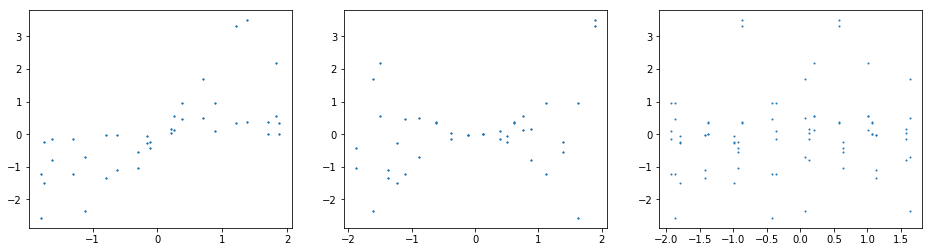

In [72]:
fig, ax = plt.subplots(1, 3, figsize=(16,4))
for i in [0,1,2]:
    ax[i].scatter(param_values[:,i], Y, s=1)

In [73]:
Y.shape

(80,)

In [74]:
def run_model(x, y):
    Y_list = []
    for i in range(len(x)):
        yy = run_basic_energysystem(x[i], y[i])
        Y_list.append(yy)
    Y = np.array(Y_list)
    return Y

problem = {
  'num_vars': 2,
  'names': ['x', 'y'],
  'bounds': [[10, 40]]
}

# Generate samples
param_values = saltelli.sample(problem, 10)
print(param_values.shape)

Y = run_model(param_values[:,0], param_values[:,1])

(60, 2)
simulation lasted:  1.4624805450439453 sec
simulation lasted:  1.357454538345337 sec
simulation lasted:  1.595731496810913 sec
simulation lasted:  1.3545756340026855 sec
simulation lasted:  1.3594422340393066 sec
simulation lasted:  1.3987133502960205 sec
simulation lasted:  1.4530277252197266 sec
simulation lasted:  1.4300587177276611 sec
simulation lasted:  1.6806421279907227 sec
simulation lasted:  1.4337313175201416 sec
simulation lasted:  1.5728423595428467 sec
simulation lasted:  1.4594287872314453 sec
simulation lasted:  1.581432580947876 sec
simulation lasted:  1.8130643367767334 sec
simulation lasted:  1.4956037998199463 sec
simulation lasted:  1.5125370025634766 sec
simulation lasted:  1.489370346069336 sec
simulation lasted:  1.4477832317352295 sec
simulation lasted:  1.7798547744750977 sec
simulation lasted:  1.5399727821350098 sec
simulation lasted:  1.7008137702941895 sec
simulation lasted:  1.699547290802002 sec
simulation lasted:  1.708510160446167 sec
simulatio

In [76]:
Y.shape

(60, 2)

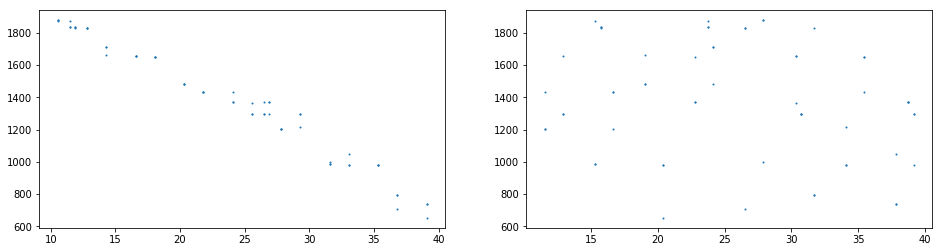

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))
for i in [0,1]:
    ax[i].scatter(param_values[:,i], Y[:,0], s=1)